<a href="https://colab.research.google.com/github/johan-naizu/solar-power-forecasting/blob/main/Solar%20Power%20Generation%20Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, TimeDistributed, Flatten, InputLayer
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/johan-naizu/dataset/refs/heads/main/dataset4.csv')
df

,timestamp_utc,power,temp,cloud_cover,shortwave_flux
0,2013-04-28 14:00:00,12038.26346,287.179138,0.000452,822.646179
1,2013-04-28 15:00:00,12681.78416,286.895630,0.008257,672.692322
2,2013-04-28 16:00:00,10785.22227,287.005615,0.174531,546.684204
3,2013-04-28 17:00:00,7758.58862,287.502197,0.170785,240.100006
4,2013-04-28 18:00:00,4142.58465,287.484985,0.109820,70.800003
...,...,...,...,...,...
26696,2016-06-28 11:00:00,10423.68080,290.545013,0.050000,901.969055
26697,2016-06-28 12:00:00,11906.68229,290.820801,0.130000,968.783386
26698,2016-06-28 13:00:00,12506.71949,290.783264,0.000000,979.095398
26699,2016-06-28 14:00:00,12351.23189,290.743866,0.000000,933.213501


In [3]:
df=df.set_index('timestamp_utc')
df=df.rename_axis('DateTime')
df

,power,temp,cloud_cover,shortwave_flux
DateTime,,,,
2013-04-28 14:00:00,12038.26346,287.179138,0.000452,822.646179
2013-04-28 15:00:00,12681.78416,286.895630,0.008257,672.692322
2013-04-28 16:00:00,10785.22227,287.005615,0.174531,546.684204
2013-04-28 17:00:00,7758.58862,287.502197,0.170785,240.100006
2013-04-28 18:00:00,4142.58465,287.484985,0.109820,70.800003
...,...,...,...,...
2016-06-28 11:00:00,10423.68080,290.545013,0.050000,901.969055
2016-06-28 12:00:00,11906.68229,290.820801,0.130000,968.783386
2016-06-28 13:00:00,12506.71949,290.783264,0.000000,979.095398


In [4]:
print(df.index.dtype)

object


In [5]:
df.index = pd.to_datetime(df.index)
df['Seconds']=df.index.map(pd.Timestamp.timestamp)
df

,power,temp,cloud_cover,shortwave_flux,Seconds
DateTime,,,,,
2013-04-28 14:00:00,12038.26346,287.179138,0.000452,822.646179,1.367158e+09
2013-04-28 15:00:00,12681.78416,286.895630,0.008257,672.692322,1.367161e+09
2013-04-28 16:00:00,10785.22227,287.005615,0.174531,546.684204,1.367165e+09
2013-04-28 17:00:00,7758.58862,287.502197,0.170785,240.100006,1.367168e+09
2013-04-28 18:00:00,4142.58465,287.484985,0.109820,70.800003,1.367172e+09
...,...,...,...,...,...
2016-06-28 11:00:00,10423.68080,290.545013,0.050000,901.969055,1.467112e+09
2016-06-28 12:00:00,11906.68229,290.820801,0.130000,968.783386,1.467115e+09
2016-06-28 13:00:00,12506.71949,290.783264,0.000000,979.095398,1.467119e+09


In [6]:
print(df.index.dtype)

datetime64[ns]


In [7]:
day = 60*60*24
year = 365.2425 * day

df['Day sin']=np.sin(df['Seconds'] * (2 * np.pi / day))
df['Day cos']=np.cos(df['Seconds'] * (2 * np.pi / day))
df['Year sin']=np.sin(df['Seconds'] * (2 * np.pi / year))
df['Year cos']=np.cos(df['Seconds'] * (2 * np.pi / year))

df

,power,temp,cloud_cover,shortwave_flux,Seconds,Day sin,Day cos,Year sin,Year cos
DateTime,,,,,,,,,
2013-04-28 14:00:00,12038.26346,287.179138,0.000452,822.646179,1.367158e+09,-5.000000e-01,-8.660254e-01,0.895247,-0.445571
2013-04-28 15:00:00,12681.78416,286.895630,0.008257,672.692322,1.367161e+09,-7.071068e-01,-7.071068e-01,0.894927,-0.446213
2013-04-28 16:00:00,10785.22227,287.005615,0.174531,546.684204,1.367165e+09,-8.660254e-01,-5.000000e-01,0.894607,-0.446854
2013-04-28 17:00:00,7758.58862,287.502197,0.170785,240.100006,1.367168e+09,-9.659258e-01,-2.588190e-01,0.894286,-0.447495
2013-04-28 18:00:00,4142.58465,287.484985,0.109820,70.800003,1.367172e+09,-1.000000e+00,-7.565194e-12,0.893965,-0.448136
...,...,...,...,...,...,...,...,...,...
2016-06-28 11:00:00,10423.68080,290.545013,0.050000,901.969055,1.467112e+09,2.588190e-01,-9.659258e-01,0.057046,-0.998372
2016-06-28 12:00:00,11906.68229,290.820801,0.130000,968.783386,1.467115e+09,8.347672e-12,-1.000000e+00,0.056331,-0.998412
2016-06-28 13:00:00,12506.71949,290.783264,0.000000,979.095398,1.467119e+09,-2.588190e-01,-9.659258e-01,0.055615,-0.998452


In [8]:
df=df.drop('Seconds',axis=1)
df

,power,temp,cloud_cover,shortwave_flux,Day sin,Day cos,Year sin,Year cos
DateTime,,,,,,,,
2013-04-28 14:00:00,12038.26346,287.179138,0.000452,822.646179,-5.000000e-01,-8.660254e-01,0.895247,-0.445571
2013-04-28 15:00:00,12681.78416,286.895630,0.008257,672.692322,-7.071068e-01,-7.071068e-01,0.894927,-0.446213
2013-04-28 16:00:00,10785.22227,287.005615,0.174531,546.684204,-8.660254e-01,-5.000000e-01,0.894607,-0.446854
2013-04-28 17:00:00,7758.58862,287.502197,0.170785,240.100006,-9.659258e-01,-2.588190e-01,0.894286,-0.447495
2013-04-28 18:00:00,4142.58465,287.484985,0.109820,70.800003,-1.000000e+00,-7.565194e-12,0.893965,-0.448136
...,...,...,...,...,...,...,...,...
2016-06-28 11:00:00,10423.68080,290.545013,0.050000,901.969055,2.588190e-01,-9.659258e-01,0.057046,-0.998372
2016-06-28 12:00:00,11906.68229,290.820801,0.130000,968.783386,8.347672e-12,-1.000000e+00,0.056331,-0.998412
2016-06-28 13:00:00,12506.71949,290.783264,0.000000,979.095398,-2.588190e-01,-9.659258e-01,0.055615,-0.998452


In [9]:
features = df.loc[:,['temp', 'cloud_cover','shortwave_flux','power','Day sin','Day cos','Year sin','Year cos']]
target = df.loc[:,['power']]

Text(0.5, 1.0, 'Temperature Time Series')

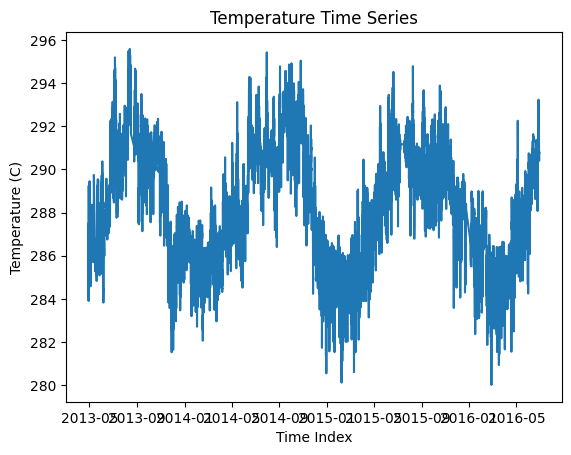

In [10]:
plt.plot(features['temp'])
plt.xlabel('Time Index')
plt.ylabel('Temperature (C)')
plt.title('Temperature Time Series')

Text(0.5, 1.0, 'Cloud Cover Time Series(Magnified)')

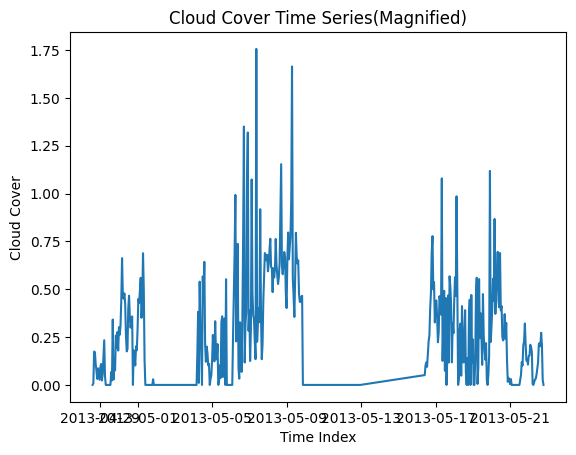

In [11]:
plt.plot(features['cloud_cover'][:500])
plt.xlabel('Time Index')
plt.ylabel('Cloud Cover')
plt.title('Cloud Cover Time Series(Magnified)')

Text(0.5, 1.0, 'Shortwave Flux Time Series')

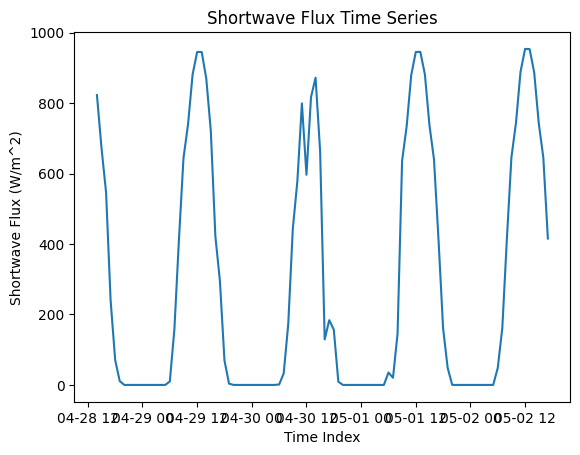

In [12]:
plt.plot(features['shortwave_flux'][:100])
plt.xlabel('Time Index')
plt.ylabel('Shortwave Flux (W/m^2)')
plt.title('Shortwave Flux Time Series')

Text(0.5, 1.0, 'Power Time Series')

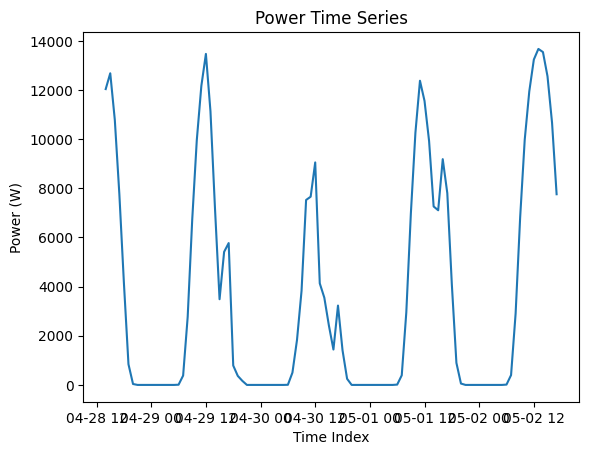

In [13]:
plt.plot(features['power'][:100])
plt.xlabel('Time Index')
plt.ylabel('Power (W)')
plt.title('Power Time Series')

Text(0.5, 1.0, 'Day Sin Time Series')

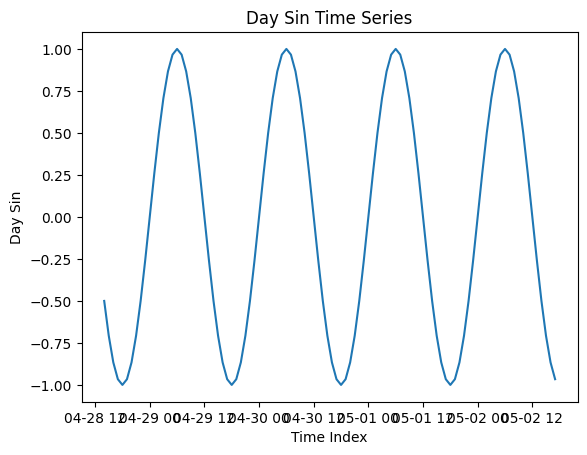

In [14]:
plt.plot(df['Day sin'][:100])
plt.xlabel('Time Index')
plt.ylabel('Day Sin')
plt.title('Day Sin Time Series')

Text(0.5, 1.0, 'Day Cos Time Series')

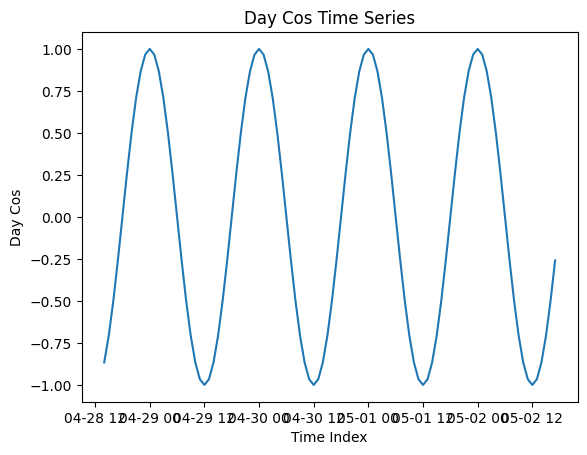

In [15]:
plt.plot(df['Day cos'][:100])
plt.xlabel('Time Index')
plt.ylabel('Day Cos')
plt.title('Day Cos Time Series')

Text(0.5, 1.0, 'Year Sin Time Series')

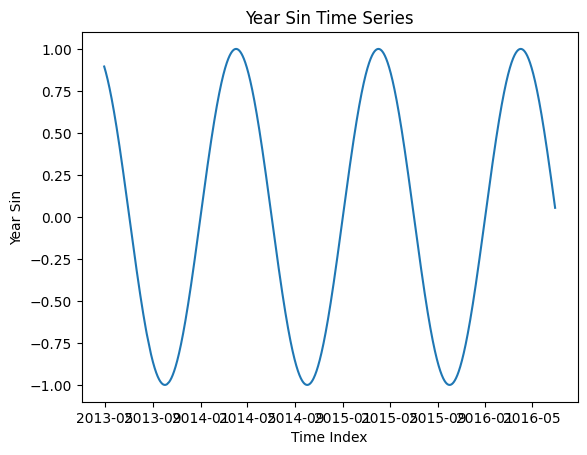

In [16]:
plt.plot(df['Year sin'])
plt.xlabel('Time Index')
plt.ylabel('Year Sin')
plt.title('Year Sin Time Series')

Text(0.5, 1.0, 'Year Cos Time Series')

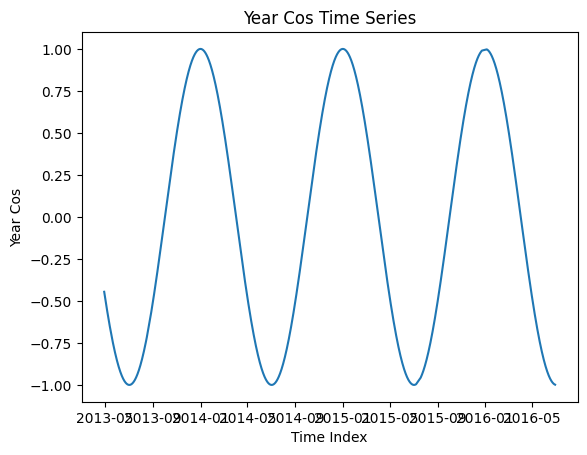

In [17]:
plt.plot(df['Year cos'])
plt.xlabel('Time Index')
plt.ylabel('Year Cos')
plt.title('Year Cos Time Series')

In [18]:
features

,temp,cloud_cover,shortwave_flux,power,Day sin,Day cos,Year sin,Year cos
DateTime,,,,,,,,
2013-04-28 14:00:00,287.179138,0.000452,822.646179,12038.26346,-5.000000e-01,-8.660254e-01,0.895247,-0.445571
2013-04-28 15:00:00,286.895630,0.008257,672.692322,12681.78416,-7.071068e-01,-7.071068e-01,0.894927,-0.446213
2013-04-28 16:00:00,287.005615,0.174531,546.684204,10785.22227,-8.660254e-01,-5.000000e-01,0.894607,-0.446854
2013-04-28 17:00:00,287.502197,0.170785,240.100006,7758.58862,-9.659258e-01,-2.588190e-01,0.894286,-0.447495
2013-04-28 18:00:00,287.484985,0.109820,70.800003,4142.58465,-1.000000e+00,-7.565194e-12,0.893965,-0.448136
...,...,...,...,...,...,...,...,...
2016-06-28 11:00:00,290.545013,0.050000,901.969055,10423.68080,2.588190e-01,-9.659258e-01,0.057046,-0.998372
2016-06-28 12:00:00,290.820801,0.130000,968.783386,11906.68229,8.347672e-12,-1.000000e+00,0.056331,-0.998412
2016-06-28 13:00:00,290.783264,0.000000,979.095398,12506.71949,-2.588190e-01,-9.659258e-01,0.055615,-0.998452


In [19]:
target

,power
DateTime,
2013-04-28 14:00:00,12038.26346
2013-04-28 15:00:00,12681.78416
2013-04-28 16:00:00,10785.22227
2013-04-28 17:00:00,7758.58862
2013-04-28 18:00:00,4142.58465
...,...
2016-06-28 11:00:00,10423.68080
2016-06-28 12:00:00,11906.68229
2016-06-28 13:00:00,12506.71949


In [20]:
print(features.shape)
print(target.shape)

(26701, 8)
(26701, 1)


In [21]:
features_scaler = MinMaxScaler()
features_scaled = features_scaler.fit_transform(features)
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target)
time_steps=200

In [22]:
#Converting 2D to 3D (instead of np.reshape)
def Reshape(features,target,time_steps):
  new_features=[]
  new_target=[]
  for i in range(features.shape[0] - time_steps):
    new_features.append([features[j+i] for j in range(time_steps)])
    new_target.append(target[i+time_steps])
  return np.array(new_features),np.array(new_target)
X_data, y_data = Reshape(features_scaled,target_scaled,time_steps)

In [23]:
print(X_data.shape)
print(y_data.shape)

(26501, 200, 8)
(26501, 1)


In [24]:
test_train_split= int(0.8*X_data.shape[0])
n_features=X_data.shape[2]

In [25]:
X_train=X_data[:test_train_split]
y_train=y_data[:test_train_split]

X_test=X_data[test_train_split:]
y_test=y_data[test_train_split:]

In [26]:
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)

print("X_test Shape: ", X_test.shape)
print("y_test Shape", y_test.shape)

print("Number of Features: ", n_features)

X_train Shape:  (21200, 200, 8)
y_train Shape:  (21200, 1)
X_test Shape:  (5301, 200, 8)
y_test Shape (5301, 1)
Number of Features:  8


In [27]:
subsequences = 10
inner_timesteps = X_train.shape[1]//subsequences

X_train = X_train.reshape((X_train.shape[0], subsequences, inner_timesteps, n_features))
X_test = X_test.reshape((X_test.shape[0], subsequences, inner_timesteps, n_features))

print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)

print("X_test Shape: ", X_test.shape)
print("y_test Shape", y_test.shape)

print("Number of Features: ", n_features)

X_train Shape:  (21200, 10, 20, 8)
y_train Shape:  (21200, 1)
X_test Shape:  (5301, 10, 20, 8)
y_test Shape (5301, 1)
Number of Features:  8


In [28]:
model1=Sequential()
model1.add(InputLayer((subsequences,inner_timesteps,n_features)))
model1.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model1.add(TimeDistributed(Flatten()))
model1.add(LSTM(128, activation='tanh',return_sequences=False))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(1 , activation='linear',kernel_regularizer=l2(0.02)))

In [29]:
cp=ModelCheckpoint('model1.keras', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [30]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 10, 18, 64)          │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 1152)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 665,793 (2.54 MB)

 Trainable params: 665,793 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model1.fit(X_train, y_train, epochs=100, callbacks=[cp,es], validation_split=0.2)

Epoch 1/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 48s 81ms/step - loss: 0.0467 - root_mean_squared_error: 0.1560 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0721
Epoch 2/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - loss: 0.0098 - root_mean_squared_error: 0.0918 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0689
Epoch 3/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 82s 84ms/step - loss: 0.0073 - root_mean_squared_error: 0.0825 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0631
Epoch 4/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - loss: 0.0069 - root_mean_squared_error: 0.0812 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0615
Epoch 5/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 81s 80ms/step - loss: 0.0064 - root_mean_squared_error: 0.0784 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0640
Epoch 6/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 81s 79ms/step - loss: 0.0063 - root_mean_squared_error: 0.0779 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0602
Epoch 7/100
530/530 ━━━━━━━━━━━━━━

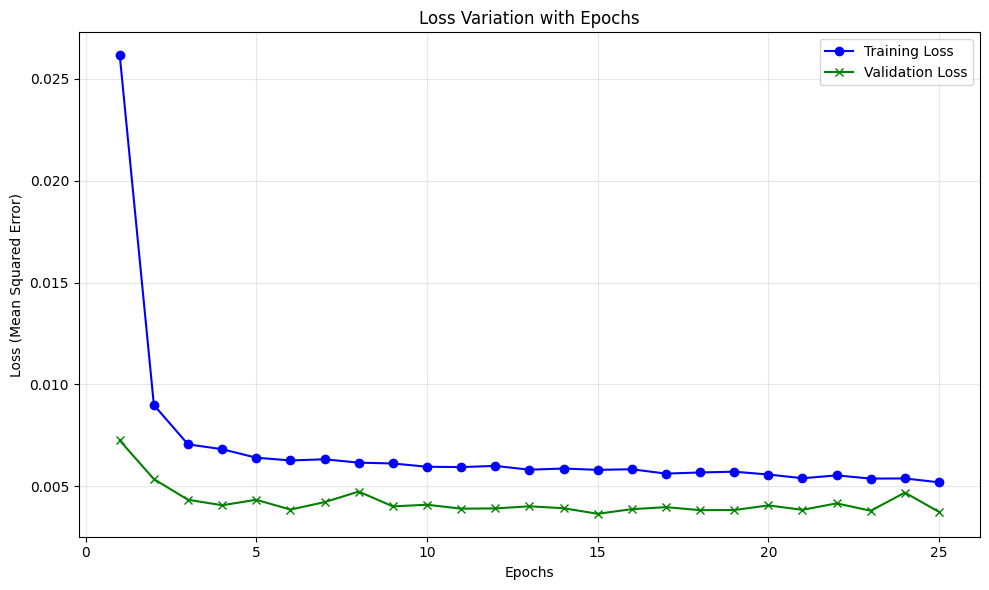

In [32]:
train_loss = history.history['loss']  # Training loss
val_loss = history.history.get('val_loss')  # Validation loss

# Plotting the loss
epochs = range(1, len(train_loss) + 1)  # Epoch numbers

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='b', marker='o')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation Loss', color='g', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.title('Loss Variation with Epochs')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:
from tensorflow.keras.models import load_model
model1=load_model('model1.keras')

In [34]:
#Evaluating Overfitting
train_predictions = model1.predict(X_train)
train_predictions = target_scaler.inverse_transform(train_predictions).flatten()
train_actuals = target_scaler.inverse_transform(y_train).flatten()
train_results=pd.DataFrame(data={'Predictions':train_predictions,'Actuals':train_actuals})
train_results

663/663 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step


,Predictions,Actuals
0,6.922781,0.00000
1,-5.379173,0.00000
2,12.665216,0.00000
3,-38.424591,0.00000
4,-52.958332,0.00000
...,...,...
21195,9309.574219,9716.32341
21196,7453.919922,8040.85714
21197,4661.478027,4868.84011
21198,1520.426147,1542.27368


In [35]:
print(train_results.shape)

(21200, 2)


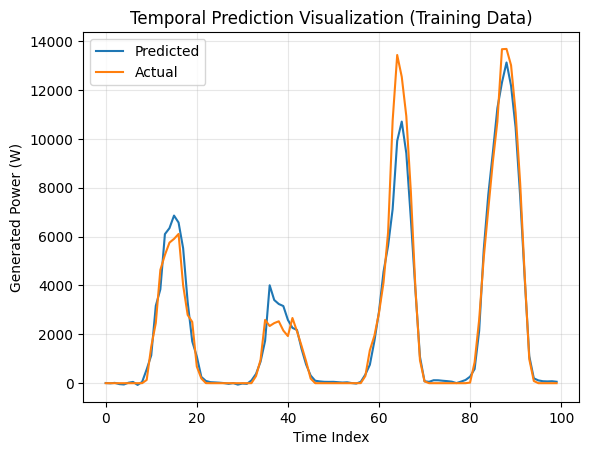

In [36]:
plt.plot(train_results['Predictions'][:100],label='Predicted')
plt.plot(train_results['Actuals'][:100],label='Actual')
plt.grid(alpha=0.3)
plt.legend()
plt.xlabel('Time Index')
plt.ylabel('Generated Power (W)')
plt.title("Temporal Prediction Visualization (Training Data)")
plt.show()

In [37]:
rmse_train = np.sqrt(mean_squared_error(train_results['Predictions'], train_results['Actuals']))
mae_train = mean_absolute_error(train_results['Actuals'],train_results['Predictions'])
mse_train = mean_squared_error(train_results['Actuals'],train_results['Predictions'])
mape_train = mean_absolute_percentage_error(train_results['Actuals'],train_results['Predictions'])
r2_train = r2_score(train_results['Actuals'],train_results['Predictions'])

In [38]:
print("Mean Absolute Error = ", mae_train)
print("Mean Squared Error = ", mse_train)
print("Root Mean Squared Error =", rmse_train)
print("Mean Absolute Percentage Error =", mape_train)
print("r2 Score =", r2_train)

Mean Absolute Error =  393.5774468772434
Mean Squared Error =  663364.0007175148
Root Mean Squared Error = 814.4716082943069
Mean Absolute Percentage Error = 1.0096637668815968e+17
r2 Score = 0.9575353493768458


In [39]:
#Test data
test_predictions = model1.predict(X_test)
test_predictions = target_scaler.inverse_transform(test_predictions).flatten()
test_actuals = target_scaler.inverse_transform(y_test).flatten()
test_results=pd.DataFrame(data={'Predictions':test_predictions,'Actuals':test_actuals})
test_results

166/166 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step


,Predictions,Actuals
0,58.796425,0.00000
1,108.672638,0.00000
2,72.142273,0.00000
3,36.066956,0.00000
4,10.157261,0.00000
...,...,...
5296,10626.911133,10423.68080
5297,12071.481445,11906.68229
5298,12750.452148,12506.71949
5299,12223.009766,12351.23189


In [40]:
print(test_results.shape)

(5301, 2)


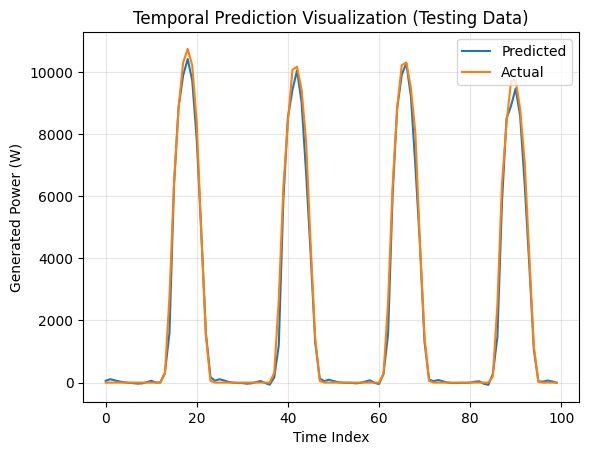

In [41]:
plt.plot(test_results['Predictions'][:100],label='Predicted')
plt.plot(test_results['Actuals'][:100],label='Actual')
plt.grid(alpha=0.3)
plt.legend()
plt.xlabel('Time Index')
plt.ylabel('Generated Power (W)')
plt.title("Temporal Prediction Visualization (Testing Data)")
plt.show()

In [42]:
rmse_test = np.sqrt(mean_squared_error(test_results['Predictions'], test_results['Actuals']))
mae_test = mean_absolute_error(test_results['Actuals'],test_results['Predictions'])
mse_test = mean_squared_error(test_results['Actuals'],test_results['Predictions'])
mape_test = mean_absolute_percentage_error(test_results['Actuals'],test_results['Predictions'])
r2_test = r2_score(test_results['Actuals'],test_results['Predictions'])

In [43]:
print("Mean Absolute Error = ", mae_test)
print("Mean Squared Error = ", mse_test)
print("Root Mean Squared Error =", rmse_test)
print("Mean Absolute Percentage Error =", mape_test)
print("r2 Score =", r2_test)

Mean Absolute Error =  433.81051010781704
Mean Squared Error =  785556.3997561053
Root Mean Squared Error = 886.3161962618675
Mean Absolute Percentage Error = 1.483281672709567e+17
r2 Score = 0.9428730520362905


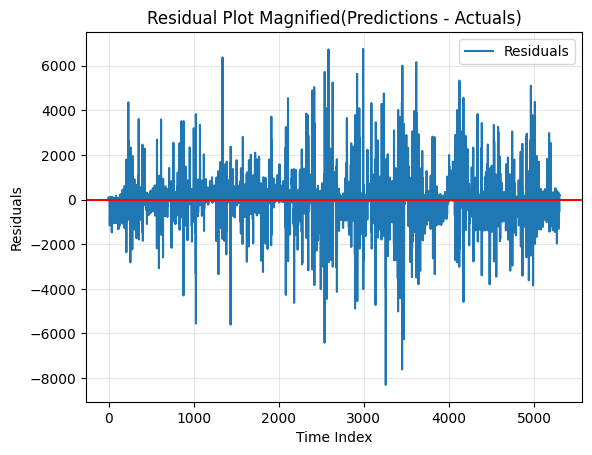

In [44]:
residual_test=pd.DataFrame(data={'Residuals':test_results['Predictions']-test_results['Actuals']})
plt.plot(residual_test['Residuals'],label='Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(alpha=0.3)
plt.legend()
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.title("Residual Plot Magnified(Predictions - Actuals)")
plt.show()

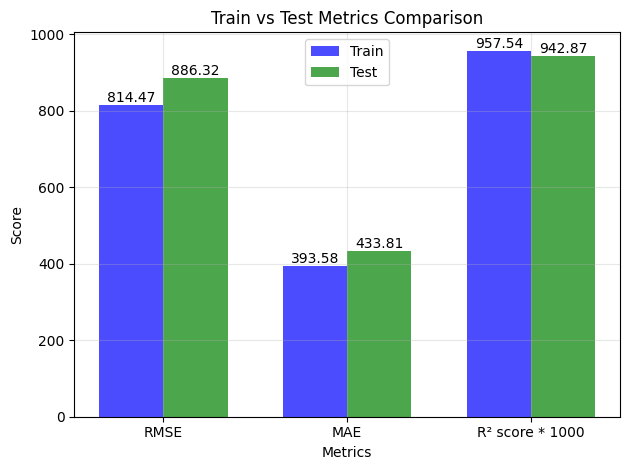

In [45]:
# Metrics for train and test data
metrics = ['RMSE', 'MAE', 'R² score * 1000']
train_scores = [rmse_train, mae_train , r2_train*1000]
test_scores = [rmse_test,mae_test,r2_test*1000]
scores_df = pd.DataFrame({'Metrics': metrics, 'Train Scores': train_scores, 'Test Scores': test_scores})

# Positions for bar groups
x = np.arange(len(metrics))
width = 0.35

# Create the plot
plt.bar(x - width/2, scores_df['Train Scores'], width, label='Train', color='b', alpha=0.7)
plt.bar(x + width/2, scores_df['Test Scores'], width, label='Test', color='g', alpha=0.7)

for i, v in enumerate(scores_df['Train Scores']):
    plt.text(x[i] - width/2, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

for i, v in enumerate(scores_df['Test Scores']):
    plt.text(x[i] + width/2, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# Add labels, title, and legend
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Train vs Test Metrics Comparison')
plt.xticks(x, scores_df['Metrics'])  # Add metric names as x-axis labels
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

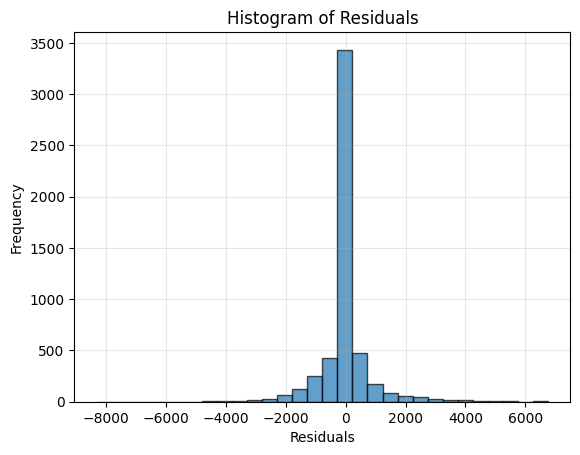

In [46]:
plt.hist(residual_test['Residuals'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(alpha=0.3)
plt.show()

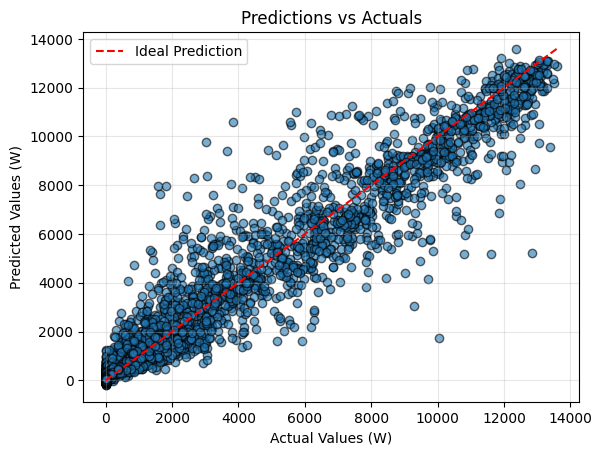

In [47]:
plt.scatter(test_results['Actuals'], test_results['Predictions'], alpha=0.6, edgecolor='k')
plt.plot([min(test_results['Actuals']), max(test_results['Actuals'])],
         [min(test_results['Actuals']), max(test_results['Actuals'])],
         color='r', linestyle='--', label='Ideal Prediction')
plt.xlabel('Actual Values (W)')
plt.ylabel('Predicted Values (W)')
plt.title('Predictions vs Actuals')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

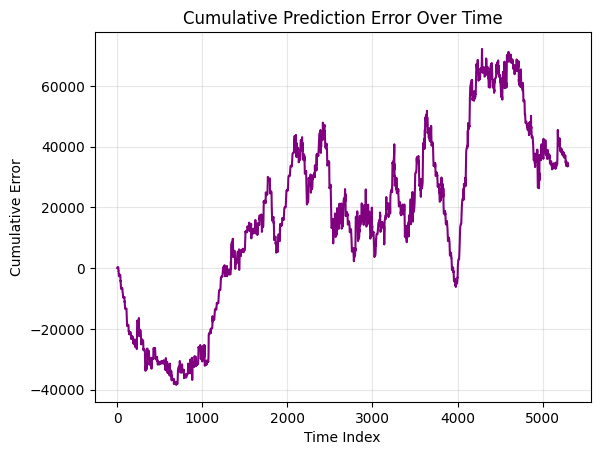

In [48]:
residual_cumsum = residual_test['Residuals'].cumsum()
plt.plot(residual_cumsum, color='purple')
plt.xlabel('Time Index')
plt.ylabel('Cumulative Error')
plt.title('Cumulative Prediction Error Over Time')
plt.grid(alpha=0.3)
plt.show()

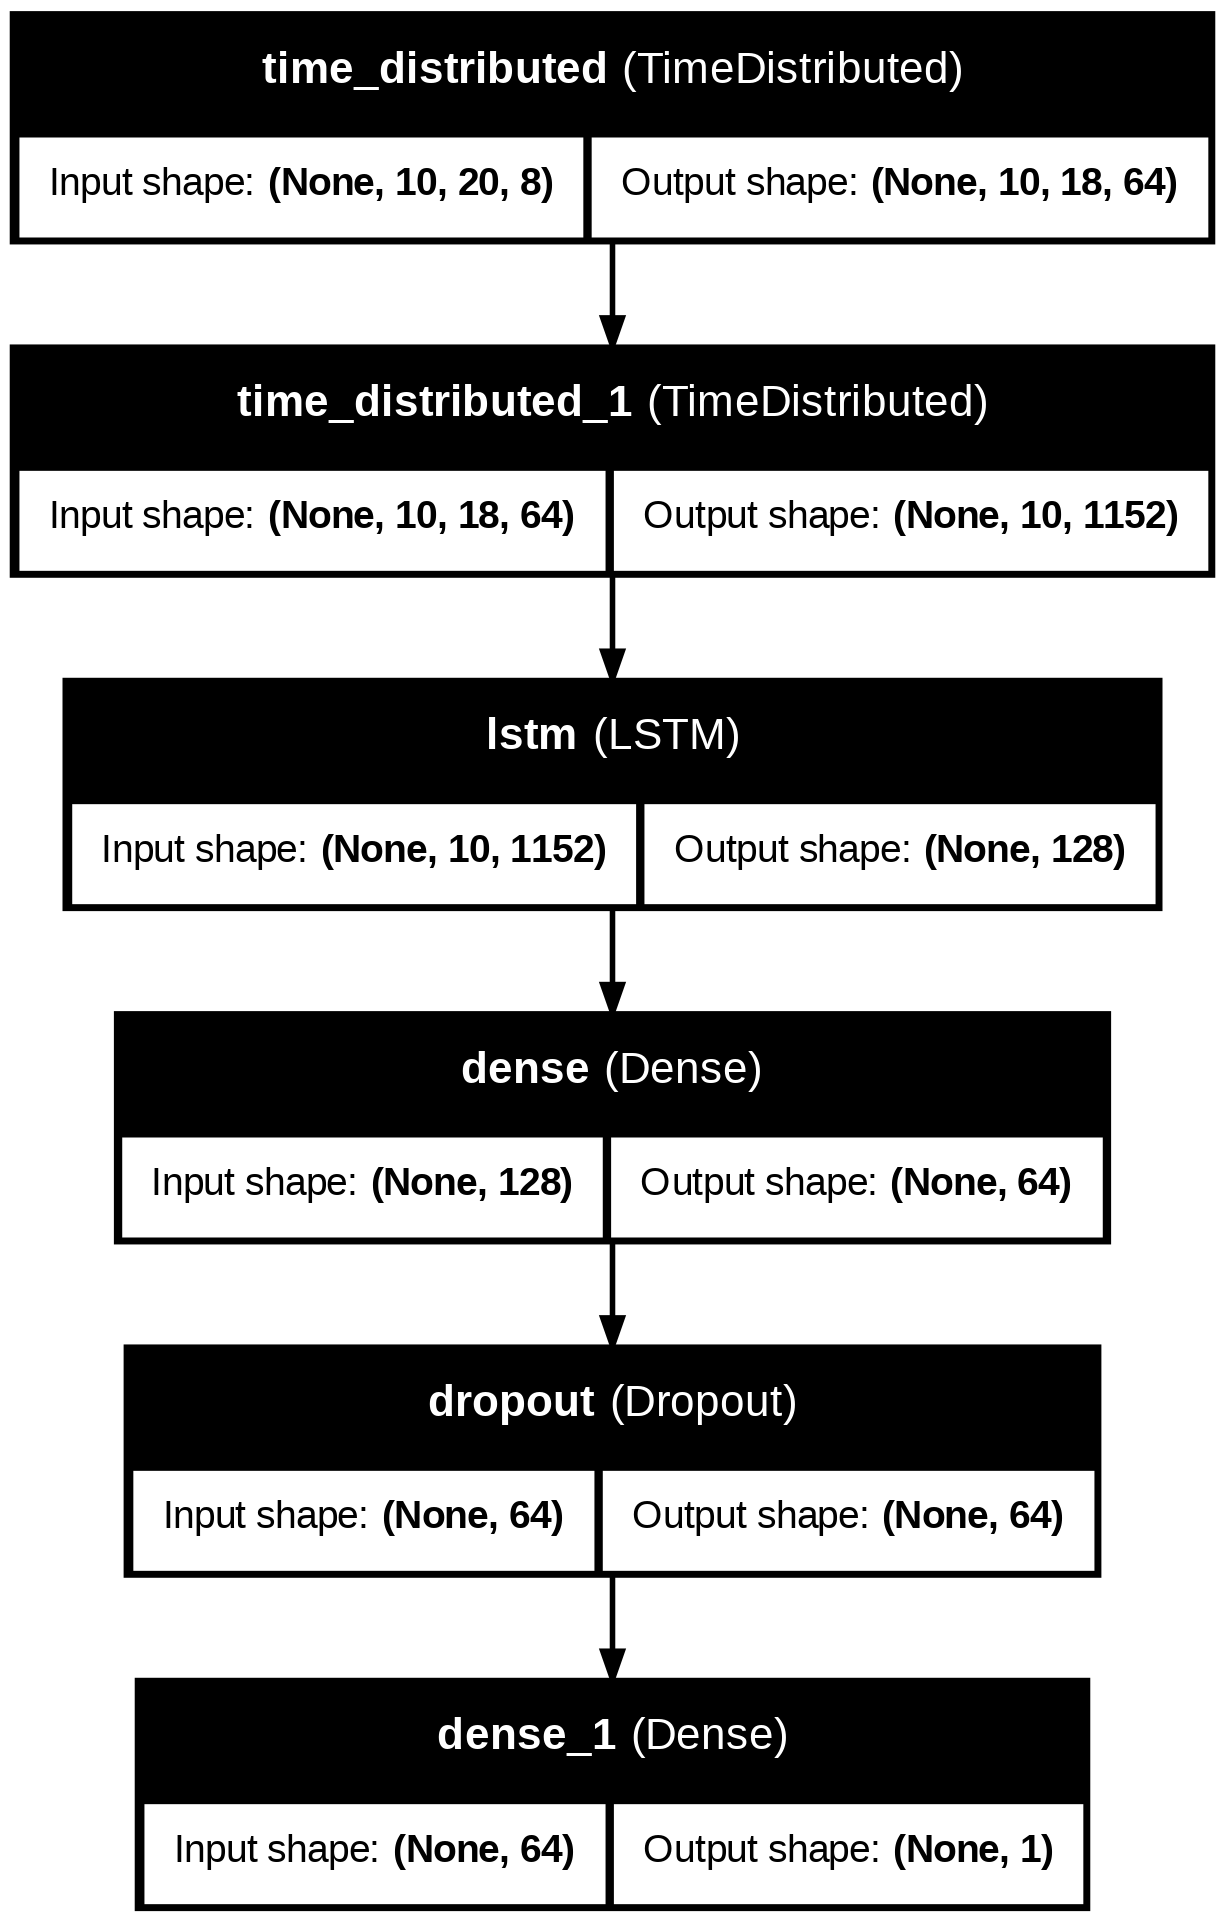

In [49]:
plot_model(model1, show_shapes=True, show_layer_names=True, to_file='model_architecture.png')